## Treliça de três barras

O objetivo do problema de otimização restrita é minimizar o gasto de material de uma treliça de três barras. Sendo que $x_1 = A_1$ é o tamanho das barras laterais e $x_2 = A_2$ é o tamanho da barra central. A função objetivo é o comprimento total das barras:

$$
\min{f(x_1, x_2)} = (2\sqrt{2})x_1 + x_2
$$

As restrições impostas ao problema são:

1. Estresse máximo das barras 1 e 2
$$
P \frac{x_2 + x_1 \sqrt{2}}{x_1^2 \sqrt{2} + 2x_1 x_2} \leq 20
$$

$$
P \frac{1}{x_1 + x_2 \sqrt{2}} \leq 20
$$

2. Estresse mínimo para a barra 3

$$
-P \frac{x_2}{x_1^2 \sqrt{2} + 2x_1 x_2} \leq -5
$$

4. Limites de tamanho para as barras

$$
0.1 \leq x_1, x_2 \leq 5
$$

P0 é factivel?
[np.float64(-14.046282150847269), np.float64(-18.092564301694537), np.float64(0.9537178491527305)]
 ==== penalidade_exterior ==== 


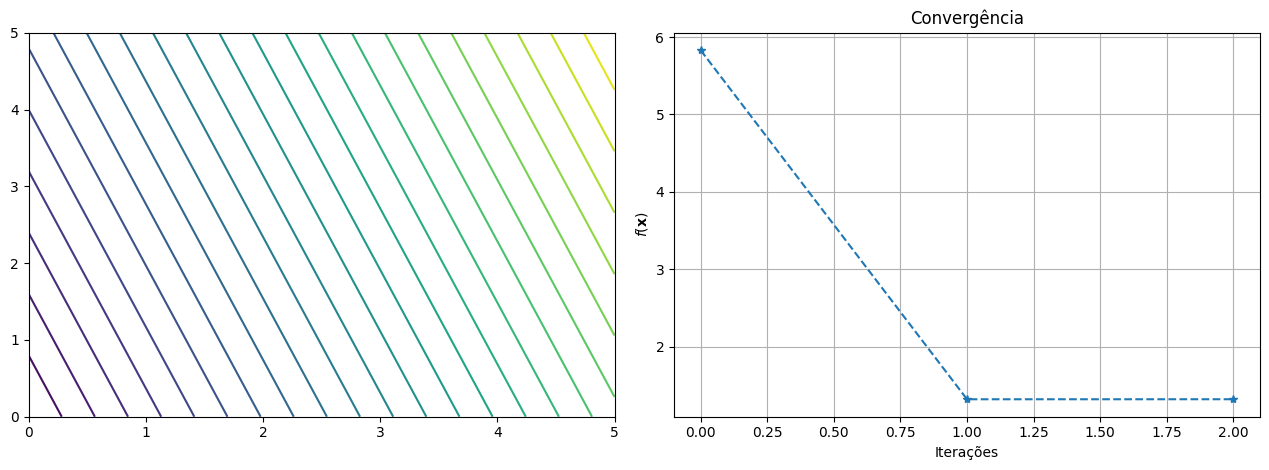

Solução ótima: [0.39391133 0.20388363]
Número de iterações: 2
Número de avaliações: 17396
Valor da função objetivo: 1.3188
 ==== lagrangeano_aumentado ==== 


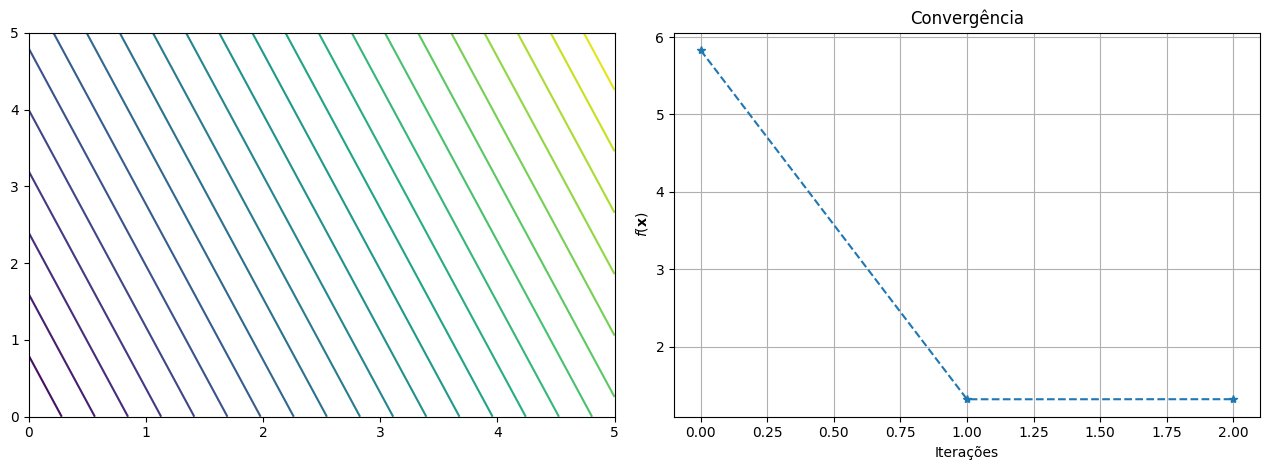

Solução ótima: [0.39406684 0.20398323]
Número de iterações: 2
Número de avaliações: 10427
Valor da função objetivo: 1.3193
 ==== Penalidade interior ====


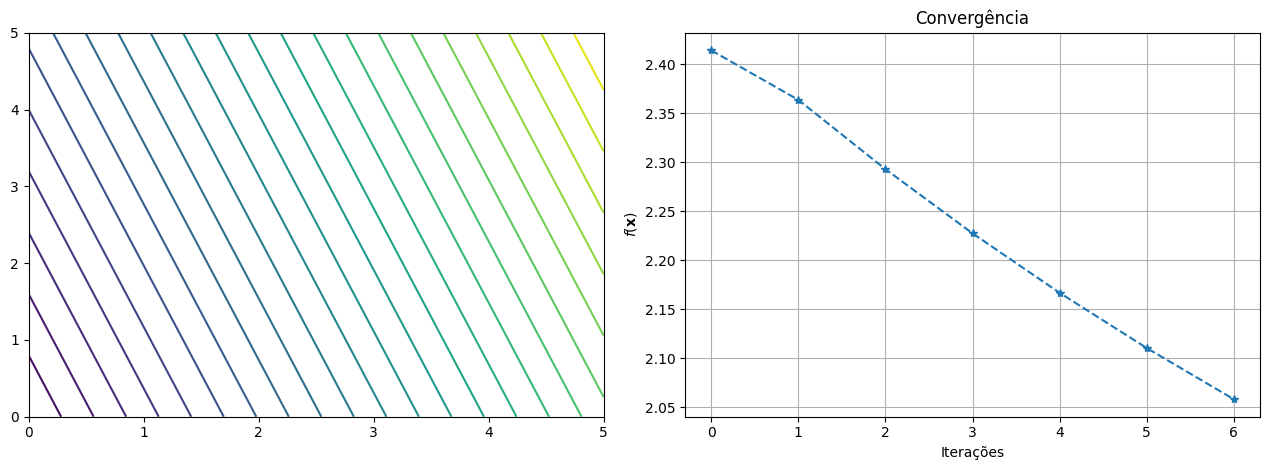

Solução ótima: [0.38184808 0.50065541]
Número de iterações: 6
Número de avaliações: 10279
Valor da função objetivo: 2.0584


In [12]:
import numpy as np
import math

import otimo

def print_solution(sol: otimo.Solution):
    print(f"Resultado: x = {sol.x}, f(x) = {sol.fx}, iterações = {sol.iter}, aval = {sol.aval}")
    print(f"critério de parada {sol.criterio_parada}")

""" Constants """

P = 10
sqrt_2 = math.sqrt(2)

""" Range Definitions """

x1_range = (0.1, 5)
x2_range = (0.1, 5)


""" Objective Function """


def objective(x):
    x1, x2 = x
    return (2 * math.sqrt(2)) * x1 + x2


""" Constraint Functions """


def g_1(x):
    x1, x2 = x
    numerator = x2 + x1 * sqrt_2
    denominator = (x1**2 * sqrt_2) + (2 * x1 * x2)

    # Handle potential division by zero
    if denominator == 0:
        return float("inf")

    return P * (numerator / denominator) - 20


def g_2(x):
    x1, x2 = x
    denominator = x1 + x2 * sqrt_2

    if denominator == 0:
        return float("inf")

    return P / denominator - 20


def g_3(x):
    x1, x2 = x
    numerator = -P * x2
    denominator = (x1**2 * sqrt_2) + (2 * x1 * x2)

    if denominator == 0:
        return float("inf")

    return (numerator / denominator) + 5


restrictions = [g_1, g_2, g_3]
tipos_de_restricoes = ["<", "<", "<"]
x0 = np.array([1.0, 3.0])  # Initial guess

print("P0 é factivel?")
print([res(x0) for res in restrictions])

busca_1d = otimo.SecaoAurea(precisao=1e-6)
irrestrito = otimo.Gradiente(busca_1d, precisao=1e-6, diferenca="regressiva")

metodos = {
    "penalidade_exterior": otimo.PenalidadeExterior(),
    "lagrangeano_aumentado": otimo.LagrangeanoAumentado(),
}


for nome, metodo in metodos.items():
    print(f" ==== {nome} ==== ")
    resultado = metodo.resolva(objective, x0,  restrictions, tipos_de_restricoes, irrestrito, disp=False)
    resultado.resultados(objective, [0, 5], [0,5], 30)
    print(resultado)

print(" ==== Penalidade interior ====")

x0 = np.array([0.5, 1])

busca_1d = otimo.SecaoAurea(precisao=1e-6, aceleracao=1.1)
irrestrito = otimo.Gradiente(busca_1d, precisao=1e-6)

solution = otimo.PenalidadeInterior().resolva(
    objective,
    x0,
    restrictions,
    tipos_de_restricoes,
    irrestrito,
    penalidade=1,
    desaceleracao=0.9,
    disp=False
)

solution.resultados(objective, [0, 5], [0,5], 30)

print(solution)

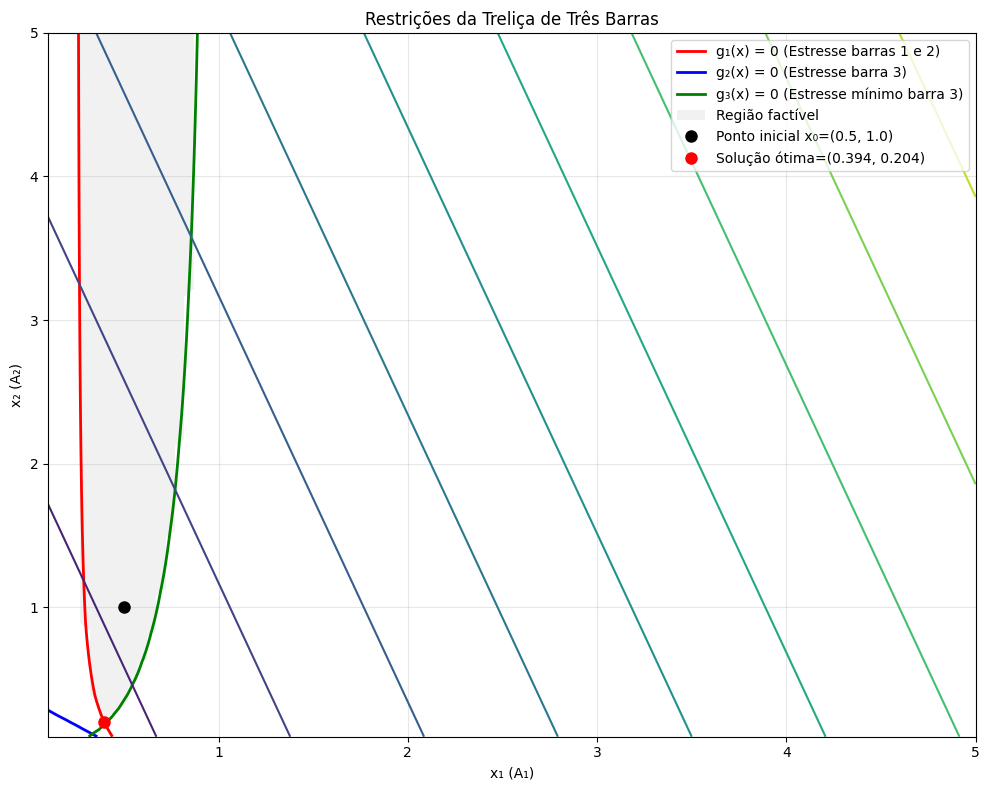

In [36]:

import matplotlib.pyplot as plt

# Create a grid of x1 and x2 values
x1 = np.linspace(0.1, 5, 100)
x2 = np.linspace(0.1, 5, 100)
X1, X2 = np.meshgrid(x1, x2)

# Calculate constraint values for each point in the grid
G1 = np.zeros_like(X1)
G2 = np.zeros_like(X1)
G3 = np.zeros_like(X1)

O = np.zeros_like(X1)

for i in range(100):
    for j in range(100):
        x = [X1[j, i], X2[j, i]]
        G1[j, i] = g_1(x)
        G2[j, i] = g_2(x)
        G3[j, i] = g_3(x)
        O[j, i] = objective(x)


# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot constraint boundaries (where g(x) = 0)
contour1 = ax.contour(X1, X2, G1, levels=[0], colors='red', linestyles='-', linewidths=2)
contour2 = ax.contour(X1, X2, G2, levels=[0], colors='blue', linestyles='-', linewidths=2)
contour3 = ax.contour(X1, X2, G3, levels=[0], colors='green', linestyles='-', linewidths=2)

obj_contou = ax.contour(X1, X2, O, levels=10)

# Fill feasible regions (where all constraints are satisfied)
feasible = (G1 <= 0) & (G2 <= 0) & (G3 <= 0)
ax.contourf(X1, X2, feasible.astype(int), levels=[0.5, 1.5], colors=['lightgray'], alpha=0.3)

# Add labels and formatting
ax.set_xlabel('x₁ (A₁)')
ax.set_ylabel('x₂ (A₂)')
ax.set_title('Restrições da Treliça de Três Barras')
ax.grid(True, alpha=0.3)

# Add legend
ax.plot([], [], 'r-', linewidth=2, label='g₁(x) = 0 (Estresse barras 1 e 2)')
ax.plot([], [], 'b-', linewidth=2, label='g₂(x) = 0 (Estresse barra 3)')
ax.plot([], [], 'g-', linewidth=2, label='g₃(x) = 0 (Estresse mínimo barra 3)')
ax.fill([], [], 'lightgray', alpha=0.3, label='Região factível')
ax.plot
ax.legend()

# Mark the initial point
ax.plot(x0[0], x0[1], 'ko', markersize=8, label=f'Ponto inicial x₀=({x0[0]}, {x0[1]})')

# Mark the optimal solution
ax.plot(resultado.x[0], resultado.x[1], 'ro', markersize=8, label=f'Solução ótima=({resultado.x[0]:.3f}, {resultado.x[1]:.3f})')

ax.legend()
plt.tight_layout()
plt.show()